In [1]:
# allows to import own functions
import sys, os, re
root_project = re.findall(r'(^\S*TFM-master)', os.getcwd())[0]
sys.path.append(root_project)


import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.ticker import PercentFormatter
from src.models.sird_model import SIRD_model
from sklearn.model_selection import ParameterSampler
from scipy.stats import uniform, expon, randint, truncexpon

sns.set()
%matplotlib inline

In [2]:
# Features to keep
dict_keys = [
    'i_country',
    'idx_country',
    'simulation_time',
    'R0',
    'Tc',
    'Tr',
    'omega',
    'inf_pow_1',
    'inf_pow_2',
    'mort_pow_1',
    'mort_pow_2',
    'mort_pow_3',
    'n_closed',
    'react_time',
    'total_infected',
    'total_deceased',
    'total_recovered',
    'new_infected_world_t',
    'new_recovered_world_t',
    'new_deceased_world_t',
    'new_infected_t',
    'new_recovered_t',
    'new_deceased_t',
    'SIRD_t',
    'SIRD_p_t',
    'SIRD_world_t',
    'SIRD_world_p_t'
]

param_list = [{'R0': 5,
  'Tr': 20,
  'countries': 'ESP',
  'n_closed': 0,
  'omega': 0.01,
  'react_time': 0}]


for simulation in param_list:
    sir_model = SIRD_model(
        simulation['R0'],
        simulation['Tr'],
        simulation['omega'],
        simulation['countries'],
        simulation['n_closed'],
        simulation['react_time'])
    sir_model.simulate()
    sir_model.compute_disease_features()
    data = sir_model.get_simulation_data() # Get the data in a dict
    subset_data = {column: data[column] for column in dict_keys}
    
s = pd.Series(subset_data)
s

i_country                                                              ESP
idx_country                                                            170
simulation_time                                                        730
R0                                                                       5
Tc                                                                       4
Tr                                                                      20
omega                                                                 0.01
inf_pow_1                                                          106.786
inf_pow_2                                                          10.4538
mort_pow_1                                                       0.0361204
mort_pow_2                                                       0.0397351
mort_pow_3                                                        0.151261
n_closed                                                                 0
react_time               

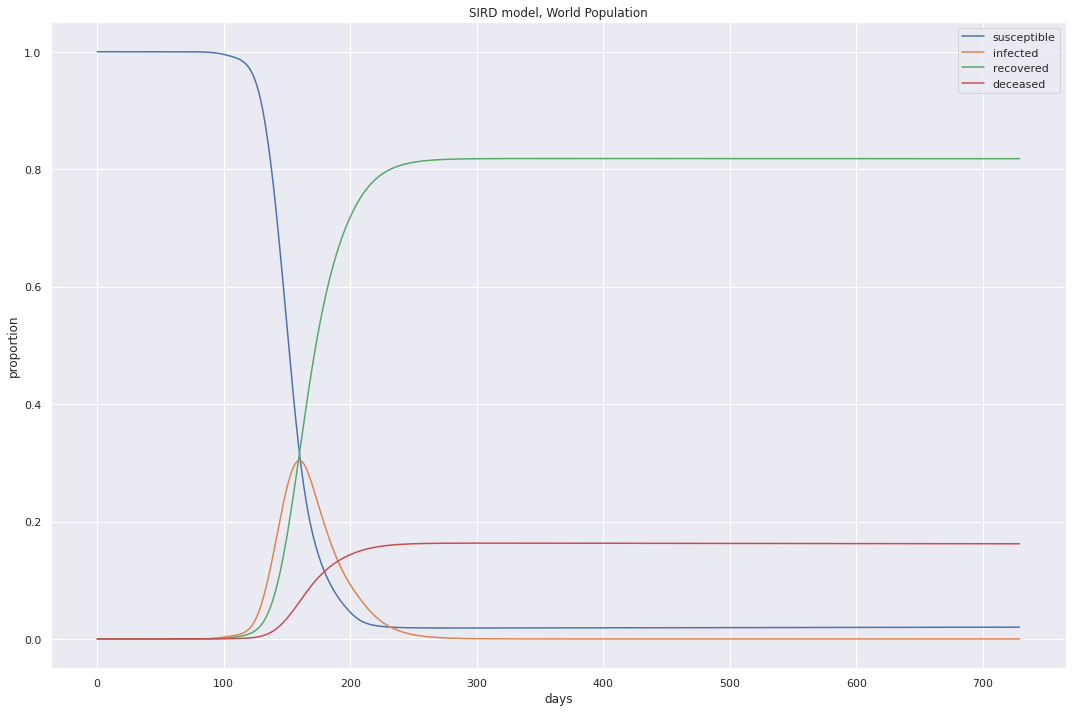

In [3]:
fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(s['SIRD_world_p_t'][0, :], label='susceptible')
ax.plot(s['SIRD_world_p_t'][1, :], label='infected')
ax.plot(s['SIRD_world_p_t'][2, :], label='recovered')
ax.plot(s['SIRD_world_p_t'][3, :], label='deceased')
ax.set(title='SIRD model, World Population',
      ylabel='proportion',
      xlabel='days')
plt.tight_layout()
ax.legend()

In [4]:
df_countries = pd.read_pickle(
    f"{root_project}/data/interim/country_info_final.pickle")

countries = [s['i_country']]
idx = []

for country in countries:
    index = df_countries.loc[df_countries["country_code"]
                             == country].index.item()
    idx.append(index)

# idx = [168, 39]  # introduce los indices de los paises a consultar

170


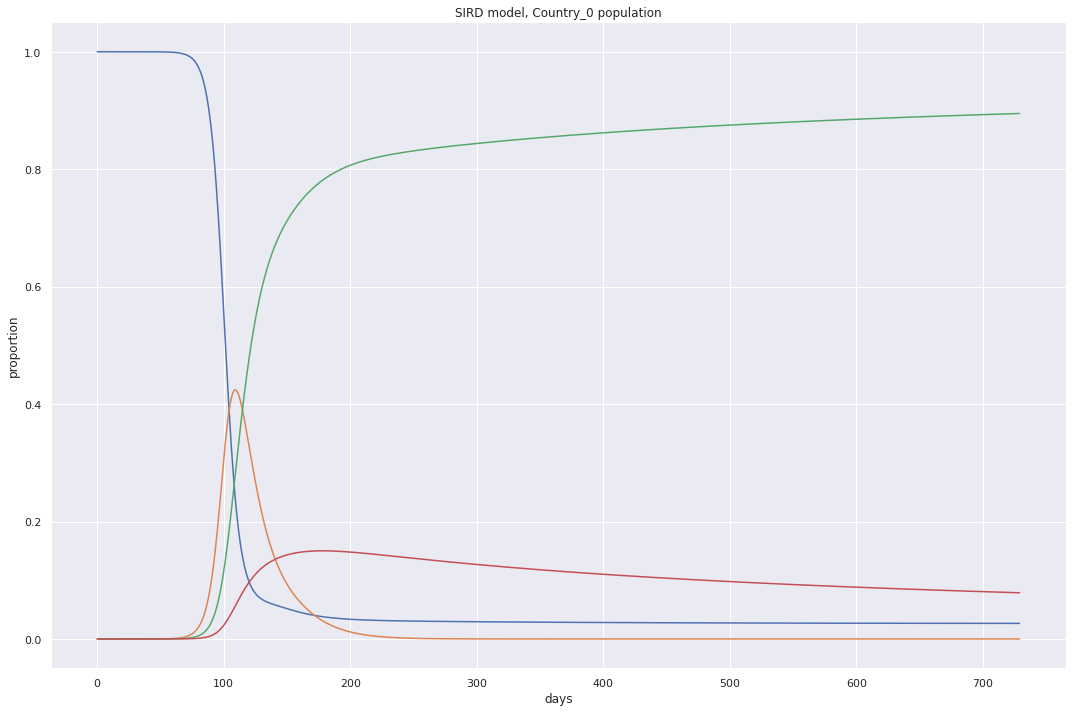

In [5]:
for i, country in zip(idx, countries):
    print(i)
    fig, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.plot(s['SIRD_p_t'][i, 0, :], label='susceptible')
    ax.plot(s['SIRD_p_t'][i, 1, :], label='infected')
    ax.plot(s['SIRD_p_t'][i, 2, :], label='recovered')
    ax.plot(s['SIRD_p_t'][i, 3, :], label='deceased')
    ax.set(title='SIRD model, Country_0 population',
      ylabel='proportion',
      xlabel='days')
    plt.tight_layout()

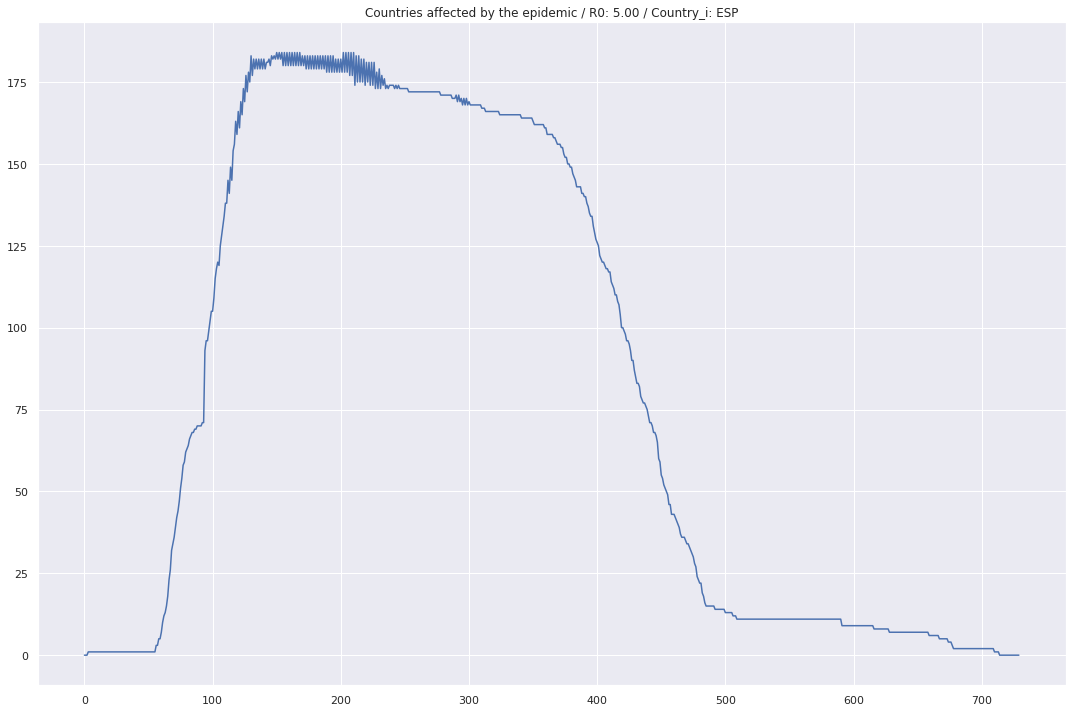

In [6]:
# para ver como evolucionan los paises afectados
affected = []
for t in range(s['simulation_time']):
    idx = np.argwhere(s['SIRD_t'][:, 1, t] > 1)
    countries = set(df_countries.iloc[idx.flatten().tolist(), 0].values)
    #print('Day {} ->'.format(t), 'Cuntries affected: {}'.format(len(countries)))
    affected.append(len(countries))


fig, ax = plt.subplots(1, 1, figsize=(15, 10))
plt.plot(np.array(affected))
plt.title(
    'Countries affected by the epidemic / R0: {:.2f} / Country_i: {}'.format(s['R0'], s['i_country']))
plt.tight_layout()

In [7]:
np.arange(100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])

In [8]:
from scipy.interpolate import BSpline
from scipy import interpolate

y = np.array(affected)
x = np.arange(len(y))
print(x.shape, y.shape)

(730,) (730,)


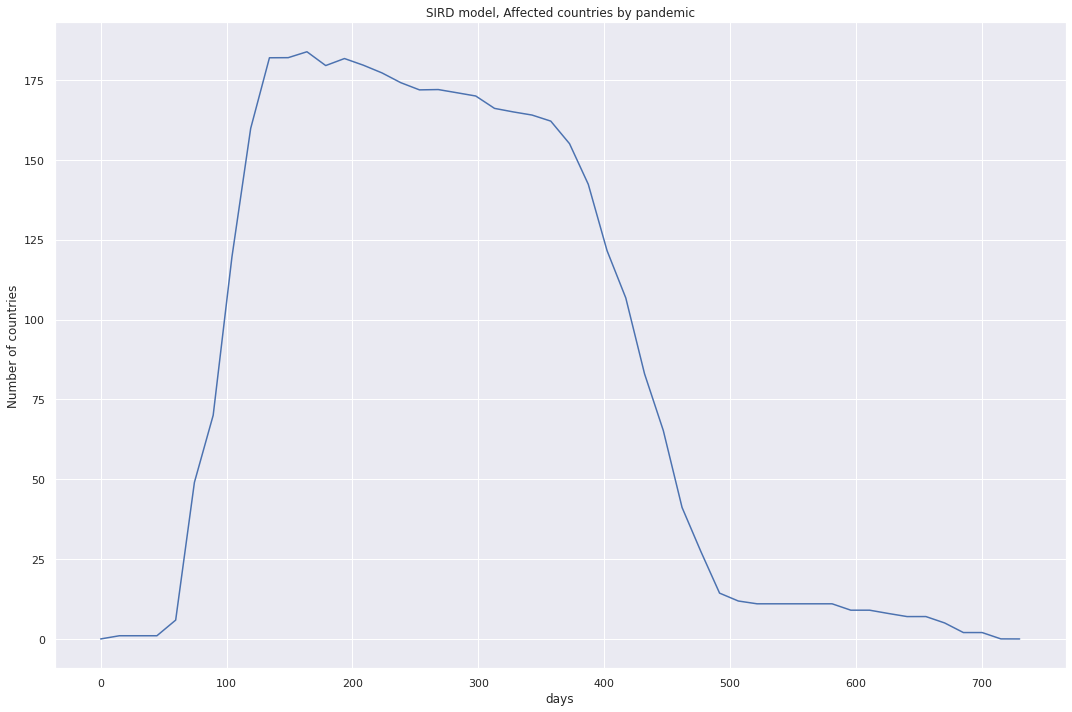

In [9]:
x_new = np.linspace(0,730)

a_BSpline = interpolate.make_interp_spline(x, y)
y_new = a_BSpline(x_new)


fig, ax = plt.subplots(1, 1, figsize=(15, 10))
ax.plot(x_new, y_new)
ax.set(title='SIRD model, Affected countries by pandemic',
  ylabel='Number of countries',
  xlabel='days')
plt.tight_layout()

No handles with labels found to put in legend.


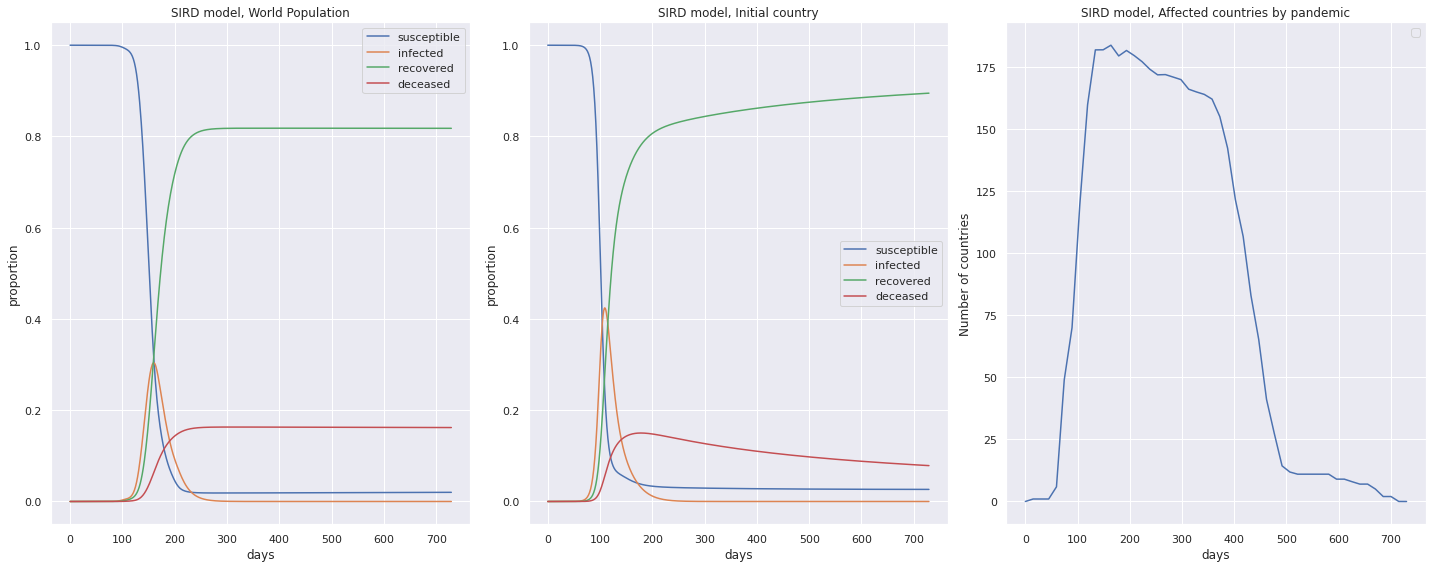

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(20, 8))

ax[0].plot(s['SIRD_world_p_t'][0, :], label='susceptible')
ax[0].plot(s['SIRD_world_p_t'][1, :], label='infected')
ax[0].plot(s['SIRD_world_p_t'][2, :], label='recovered')
ax[0].plot(s['SIRD_world_p_t'][3, :], label='deceased')
ax[0].set(title='SIRD model, World Population',
      ylabel='proportion',
      xlabel='days')
plt.tight_layout()
ax[0].legend()

ax[1].plot(s['SIRD_p_t'][170, 0, :], label='susceptible')
ax[1].plot(s['SIRD_p_t'][170, 1, :], label='infected')
ax[1].plot(s['SIRD_p_t'][170, 2, :], label='recovered')
ax[1].plot(s['SIRD_p_t'][170, 3, :], label='deceased')
ax[1].set(title='SIRD model, Initial country',
  ylabel='proportion',
  xlabel='days')
plt.tight_layout()
ax[1].legend()


ax[2].plot(x_new, y_new)
ax[2].set(title='SIRD model, Affected countries by pandemic',
  ylabel='Number of countries',
  xlabel='days')
ax[2].legend()
plt.tight_layout()
